In [1]:
from __future__ import print_function
import glob, itertools, os, subprocess, re
import sys, time, tqdm, itertools, socket
import mdtraj as md
import msmbuilder.utils
import numpy as np
import itertools
from itertools import groupby, count
import matplotlib
%matplotlib inline
# Script: matplotlib.use('Agg')  | Notebook: %matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from msmbuilder.cluster import KCenters, KMeans, KMedoids
from msmbuilder.decomposition import tICA
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.msm import ContinuousTimeMSM, implied_timescales, MarkovStateModel
from operator import itemgetter
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
#from pymbar import MBAR
from pyemma.thermo import mbar

'''This script has lots of functionality and is based on analyzing Gromacs trajectories. A list of trajectory
   files is given as trajectory_files, as well as a general structure file. Other structure files should contain
   the same name as the corresponding trajectory file, e.g. traj_001.trr traj_001.gro.
'''

# this project represents a spiroligomer (1) from https://doi.org/10.1371/journal.pone.0045948
# bound to MDM2 (PDB: 1ycr)
# these runs represent the 20 ensembles: lam = false, d = {0.1, 2.0, 0.1}

# featurization parameters
project_title = 'PROJ14086' # creates sub-directory
structure_file = '%s/xtc.gro'%project_title
runs = 203 #len(glob.glob('%s/traj_data/RUN*'%project_title))
clones = 100 #max([len(glob.glob('%s/traj_data/RUN%d/*'%(project_title,x))) for x in range(runs)])
md_time_step = 0.01 # time in ns that trajectory files are saved (nstxtcout)
equil_time = 1. # time in ns to remove from beginning of each clone
subsampled_time_step = 0.25 # preferred subsampled time-step in ns
stride = int(subsampled_time_step / md_time_step) # time step stride for sub-sampling
equil_steps = int(equil_time / md_time_step) # time steps to be removed from start
custom_residues = ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A'] # for spiroligomers
custom_residues += ['1MQ','20Q','20U','I18','I31','K23','NUT','YIN'] # for nutlins

# tICA/MSM parameters
tica_lagtime = 10 # determine from implied timescales / GMRQ
n_components = 8 # how many tICs to compute
n_clusters = 100 # denotes number of microstates
n_timescales = n_components # plot all eigenvalues --> timescales
lagtimes = np.array([1,2,4,8,16,32,64,128,256,512,1024]) # log scale
cluster_method = 'kcenters' # 'kcenters/kmeans/kmedoids'
all_ticas = list(itertools.permutations(range(1,n_components+1), 2)) # all combinations
all_ticas = [[1,2]] # override: just show analysis for first two components
cluster_percentage_cutoff = n_clusters/64 # clusters with a relative population less than this
                              # number will not be labeled on plot i.e. 0 : all clusters labeled
    
# MBAR/TRAM parameters
K = runs # sets n_ensembles = n_runs
L = K # secondary ensemble count for MBAR
kspring_k = [200.0] * K # spring constant for each ensemble in kJ/mol/nm^2
equilibrium_distances = [0.1+0.1*k for k in range(K)]
protein_anchor = 555
restrained_distance_indices = [[[555,'COM']]]*K # which distances are restrained for each
restrained_distance_labels = ['d555-ligand_COM']*K # restraint labels for plots
temperature = 300.0 # in K
T_k = np.ones(K,float)*temperature # This simulation uses only 300K sampling
kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))

print('Current Directory: %s'%os.getcwd())

/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Current Directory: /media/matt/ext/projects/nutlins


In [15]:
def compute_distances():
    
    """Calculate pair-wise distance features and save as .npy files.
       Index selection is done within the function.
       Feature labels are returned to match tICA components back to the features that make them up.
    """
    
    print("\nCalculating distances...")
    
    if not os.path.exists(project_title + '/features'):
        os.mkdir(project_title + '/features')
    
    verbose = False
    protein_residues = range(46,60) # residue indices for MDM2 binding helix
    trajectory_files = []
    skipped = 0
    
    for run in range(runs):
        trajectory_files += sorted(glob.glob('%s/traj_data/RUN%d/*xtc'%(project_title,run)))

    for i in tqdm.tqdm_notebook(range(len(trajectory_files))): # For each trajectory file
        traj = md.load(trajectory_files[i], top=structure_file)
        if verbose:
            print("Loaded " + trajectory_files[i] + " with top: " + structure_file)

        # custom residue definition
        custom_residues = ['1MQ','20Q','20U','I18','I31','NUT','YIN','K23']
        custom_residues += ['B1A','B1B','B2A','B2B','B2C','B2D','B2E','B3A','B3B']
        custom_residues += ['B4A','B4B','B4C','B4D','B5A','B5B','B5C','B6A']

        # index selection
        protein_indices = [ a.index for a in traj.topology.atoms if a.name in ['CA'] and a.residue.index in protein_residues and a.residue.name not in custom_residues]
        ligand_indices = [ a.index for a in traj.topology.atoms if a.element.symbol == 'C' and a.residue.name in custom_residues]

        # transform indices into distances and save
        pairs = list(itertools.product(protein_indices[::3], ligand_indices[::3]))
        
        # ensure that number of features is greater than the length of the strided
        # trajectory, so the autocorrelation matrix is guaranteed to be positive definite.
        if len(pairs) > len(traj[equil_steps:][::stride]):
            if verbose:
                print("Number of features (%d) exceeds strided trajectory length (%d). Skipping.\n" %(len(pairs),len(traj)/stride))
            skipped += 1
            continue
        
        # these are returned and are useful for mapping tICA components back to the 
        # atoms and residues that correspond to each feature.
        feature_labels = [[[str(traj.topology.atom(j[0]).residue.index) +
                            traj.topology.atom(j[0]).residue.name,traj.topology.atom(j[0]).name],
                          [str(traj.topology.atom(j[1]).residue.index) + 
                           traj.topology.atom(j[1]).residue.name,traj.topology.atom(j[1]).name]] for j in pairs]
        
        features = AtomPairsFeaturizer(pairs)
        transformed_data = features.fit_transform(traj[equil_steps:][::stride])
        
        for j in range(len(transformed_data)):
            transformed_data[j] = transformed_data[j][0]
        
        if verbose:
            print("Saved %d pair-wise distance features over %d frames.\n" %(len(pairs),len(transformed_data)))
        feature_file = re.sub('.xtc','',re.sub('traj_data/RUN.*/','features/',trajectory_files[i]))
        np.save(feature_file, transformed_data)
    
    print('Skipped %d/%d (%.3f%%) trajectories because number of features exceeded strided frames.'%(skipped,len(trajectory_files),float(100*skipped/len(trajectory_files))))
    print('If this number seems too high, decrease number of features or decrease stride.')
    return feature_labels

for project_title in ['PROJ14086']:
    labels = compute_distances()


Calculating distances...



Skipped 116/596 (19.463%) trajectories because number of features exceeded strided frames.
If this number seems too high, decrease number of features or decrease stride.


In [5]:
def compute_tica_components():
          
    '''Load in the features, calculate a given number of tICA components (tica_components) given a
       lagtime (lag_time), and save tICA coordinates and eigenvector data. It then creates and populates
       a list for each desired component, clusters the data, saving normalized populations as populations.dat
       and saving each cluster center as a .pdb. tICA plots are created and saved, and implied timescales are
       calculated, saved, and plotted.
    '''
          
    print("\nCalculating tICA components...")
    if not os.path.exists(project_title + '/tica'):
        os.mkdir(project_title + '/tica')
        
    verbose = False
    color_by_run = True
    run_selection = range(runs)
    save_pdb = True
    
    
    # load in feature files
    frame, run_frames = 0, [0]
    features, feature_files = [],[]
    run_selection = range(runs) # all runs
    for i in run_selection:
        feature_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
        run_features = [ np.load(filename) for filename in feature_files]
        frame += np.sum([np.shape(x)[0] for x in run_features])
        run_frames.append(frame)
        features += run_features 
    #feature_files = []
    #for i in range(runs):
    #    feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
    #features = [ np.load(filename) for filename in feature_files]
    
    # perform tICA calculation and extract score / eigenvectors
    tica_coordinates = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit_transform(features)
    tica_components = tICA(lag_time=tica_lagtime,
        n_components=int(n_components)).fit(features)
    eigenvectors = np.transpose(tica_components.eigenvectors_)
    tica_score = tica_components.score(features)
          
    np.save(project_title + '/tica/' + 'tica_coords-lag_%d-comp_%d.npy' %(tica_lagtime, n_components), tica_coordinates)
    np.save(project_title + '/tica/' + 'tica_comps-lag_%d-comp_%d.npy' %(tica_lagtime, n_components), tica_components)
    
    # Perform clustering based on the cluster_method parameter.
    if cluster_method == 'kcenters':
        print('Clustering via KCenters...')
        clusters = KCenters(n_clusters)
    elif cluster_method == 'kmeans':
        print('Clustering via KMeans...')
        clusters = KMeans(n_clusters)
    elif cluster_method == 'kmedoids':
        print('Clustering via KMedoids...')
        clusters = KMedoids(n_clusters)
    else:
        sys.exit('Invalid cluster_method. Use kcenters/kmeans/kmedoids.')
        
    # Determine cluster assignment for each frame.      
    sequences = clusters.fit_transform(tica_coordinates)
    np.save(project_title + '/tica/' + 'lag_%d_clusters_%d_assignments.npy' %(tica_lagtime, n_clusters), sequences)
    np.save(project_title + '/tica/' + 'lag_%d_clusters_%d_center.npy' %(tica_lagtime, n_clusters),
        clusters.cluster_centers_)

    # Determine cluster populations, normalize the counts, and save as percentages for
    # labeling if a cluster contains more than cluster_percentage_cutoff percent of the data.
    # Finally, save normalized counts.
    
    print("\nDetermining cluster populations...")
    if not os.path.exists(project_title + '/tica/%s_clusters'%cluster_method):
        os.mkdir(project_title + '/tica/%s_clusters'%cluster_method)
    if not os.path.exists(project_title + '/tica/plots'):
        os.mkdir(project_title + '/tica/plots')
        
    counts = np.array([len(np.where(np.concatenate(sequences)==i)[0]) for i in range(n_clusters)])
    normalized_counts =  counts/float(counts.sum())
    percentages = [ i*100 for i in normalized_counts ]
    population_labels = [ [i,"%.2f"%percentages[i]] for i in range(len(percentages)) if percentages[i] > cluster_percentage_cutoff ]
    np.savetxt(project_title + '/tica/%s_clusters/populations.dat'%cluster_method, normalized_counts)

    # Plot all unique combinations of tICA components
    print("\nPlotting tICA components...")
    tica_coordinates = np.concatenate(tica_coordinates)
    for j in tqdm.tqdm(range(len(all_ticas)),leave=False): # For each pair
        if all_ticas[j][0] < all_ticas[j][1]:
            plt.figure(j, figsize=(20,16))
            tICx, tICy = all_ticas[j][0]-1, all_ticas[j][1]-1
            plt.hexbin(tica_coordinates[:,tICx],tica_coordinates[:,tICy], bins='log')
            
            if color_by_run:
                legend_elements = []
                colors = cm.rainbow(np.linspace(0,1,runs))
                for k in range(len(run_frames)):
                    if k < K-1:
                        plt.scatter(tica_coordinates[:,tICx][run_frames[k]:run_frames[k+1]][::stride*2],
                               tica_coordinates[:,tICy][run_frames[k]:run_frames[k+1]][::stride*2],
                               color=colors[k])
                        legend_elements.append(Line2D([0], [0], marker='o', color=colors[k],
                            label="d=%.2f"%equilibrium_distances[k], markerfacecolor=colors[k], markersize=8))
                plt.legend(handles=legend_elements, loc='best')
            
            x_centers = [clusters.cluster_centers_[i][tICx] for i in range(len(clusters.cluster_centers_))]
            y_centers = [clusters.cluster_centers_[i][tICy] for i in range(len(clusters.cluster_centers_))]
            high_pop_x_centers = [ x_centers[i] for i in range(len(x_centers)) if percentages[i] > cluster_percentage_cutoff ]
            high_pop_y_centers = [ y_centers[i] for i in range(len(y_centers)) if percentages[i] > cluster_percentage_cutoff ]
            plt.plot(x_centers, y_centers, color='y', linestyle="", marker="o")
            plt.plot(tica_coordinates[:,tICx][0],tica_coordinates[:,tICy][0], color='k', marker='*',markersize=24)
            plt.xlabel('tic'+str(all_ticas[j][0]))
            plt.ylabel('tic'+str(all_ticas[j][1]))
            plt.title(project_title)
            # Add labels for high-population cluster centers
            for label, x, y in zip(population_labels, high_pop_x_centers, high_pop_y_centers):
                plt.annotate(
                  label,
                  xy = (x, y), xytext = (-15, 15),
                  textcoords = 'offset points', ha = 'right', va = 'bottom',
                  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            plt.savefig(project_title + '/tica/plots/' + 'tica_'+str(all_ticas[j][0])+'_'+str(all_ticas[j][1])+'.png')
            plt.close()


    # Calculate and save cluster entropy
    print('\nDetermining cluster entropy...')
    cluster_entropy = (-kB*temperature*normalized_counts*np.log(normalized_counts)).sum()
    print(cluster_entropy)
    # np.savetxt(project_title + '/' + 'cluster_entropy.dat', cluster_entropy)

          
    # Write out PDBs for each cluster center
    print("Performing cluster analytics and saving center PDBs...\n")
    if save_pdb:
        trajectory_files = []
        for run in range(runs): # get only xtc files that correlate to npy files
            trajectory_files += [re.sub('features',
                                    'traj_data/RUN%d'%run,re.sub('npy','xtc',x)
                                     ) for x in sorted(glob.glob('%s/features/*R%d_*npy'%(project_title,run)))] 

        for i in tqdm.tqdm_notebook(range(len(features)),leave=False):
            n_snapshots = len(clusters.distances_[i])

            # Determine frames that are cluster centers
            cluster_indices = np.arange(n_snapshots)[ (clusters.distances_[i] < 1e-6) ]
            # Determine number of each cluster, correlates to populations.dat
            cluster_labels = sequences[i][cluster_indices]

            # Save each cluster center as a pdb
            if list(cluster_indices): # load center-containing xtcs to check length
                xtc_len = len(md.load(trajectory_files[i],top=structure_file))

            for j in range(len(cluster_indices)):
                frames = range(xtc_len) # map the strided frame number back to xtc frame number
                strided_frames = frames[equil_steps:][::stride]
                xtc_frame = frames.index(strided_frames[cluster_indices[j]])
                cluster_traj = md.load_frame(trajectory_files[i], xtc_frame, top=structure_file)
                cluster_traj.save_pdb(project_title + '/tica/%s_clusters/state_%d_%.3f.pdb'%(cluster_method,
                                    cluster_labels[j],percentages[cluster_labels[j]]))
                if verbose:
                    print('Successfully saved PDB for cluster: %d, (rel.pop: %.3f)'%(cluster_labels[j],percentages[cluster_labels[j]]))
                    print('traj_file: %s (%d/%d)'%(trajectory_files[i],i,len(features)))
                    print('frame: %d (%d/%d centers from this trajectory)'%(cluster_indices[j],j,len(cluster_indices)))
                    print('strided: npy_frame/npy_len = %d/%d = %f'%(cluster_indices[j],n_snapshots,cluster_indices[j]/n_snapshots))
                    print('re-mapped: orig_frame/xtc_len = %d/%d = %f\n'%(xtc_frame,xtc_len,xtc_frame/xtc_len))
    return tica_score

project_title = 'PROJ14090'
tica_score = compute_tica_components()



Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...



Determining cluster entropy...
5.73161049952
Performing cluster analytics and saving center PDBs...



OSError: No such file: PROJ14090/traj_data/RUN0/P14090_R0_C0.xtc

In [4]:
def compute_msm():
    
    # are ITS lagtimes in timesteps?
    # ITS not working
    
    verbose = False
    
    assignments = np.load(project_title + '/tica/lag_%d_clusters_%d_assignments.npy'%(tica_lagtime,n_clusters))
    msm = MarkovStateModel(n_timescales=n_components, lag_time=tica_lagtime, reversible_type='transpose',
                           verbose=False, sliding_window=True, ergodic_cutoff='on')
    msm.fit(assignments)
    msm_score = msm.score(assignments)
    
    # Calculate and save Implied Timescales
    if verbose:
        print("\nCalculating Implied Timescales...")
    #timescales = implied_timescales(assignments, lagtimes, n_timescales=n_components, msm=msm)
    #timescales_file = project_title + '/tica/lag_%d_clusters_%d_timescales.npy' %(tica_lagtime, n_clusters)
    #np.savetxt(project_title + '/tica/lagtimes.txt', lagtimes)
    #np.save(numpy_timescale_data, timescales)

    # Plot Implied Timescales per lagtime
    #if verbose:
    #    print("\nPlotting Implied Timescales...")
    #for i in tqdm.tqdm(range(n_timescales),leave=False):
    #    plt.figure()
    #    plt.plot(lagtimes * md_time_step, timescales[:, i] * time_step, 'o-')
    #    plt.yscale('log')
    #    plt.xlabel('lagtime (ns/timestep?)') # Is this scale always true?
    #    plt.ylabel('Implied timescales (ns/timestep?)') # This one?
    #    plt.title(project_title + ' Implied timescales')
    #    plt.savefig(project_title + '/' + 'lag_%d_clusters_%d_.png' %(tica_lagtime, n_clusters))
    
    return msm_score

In [5]:
def compute_center_of_mass(traj, atom_indices=None):
    
    """
    Compute the center of mass for each frame.
    Parameters:
    ----------
    traj : Trajectory
        Trajectory to compute center of mass for
    atom_indices : list of int
        Atoms to compute center of mass for. If None,
        will compute over all atoms
    Returns
    -------
    com : np.ndarray, shape=(n_frames, 3)
         Coordinates of the center of mass for each frame
    """

    if atom_indices is None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)

    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in traj.top.atoms])
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()

    #for i, x in enumerate(traj.xyz):
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [6]:
def compute_restraint_distances():
    
    """Computes un-(strided/equilibrated) umbrella restraint distances and 
       saves a numpy.savetxt(shape=(num_conf_states(frames),3)) 
       for each run, saving clone and timestep and distance for each frame."""
    
    print('\nComputing restraint distances...')
    distances_path = project_title + '/umbrella_distances'
    if not os.path.exists(distances_path):
        os.mkdir(distances_path)

    for k in tqdm.tqdm_notebook(range(K)):
        f = open('%s/run_%d_dists.dat'%(distances_path,k),'w')
        f.write('#clone\ttime(ns)\t%s\n'%restrained_distance_labels[k])

        traj_files = [re.sub('npy','xtc',re.sub('features','traj_data/RUN%d'%k,x)) for x in sorted(glob.glob(
            '%s/features/P*R%d_*npy'%(project_title,k)))]
        reordered_clones = [re.sub('.*C','',re.sub('.xtc','',x)) for x in traj_files]
                                              
        for j in range(len(traj_files)):
            traj = md.load(traj_files[j], top=structure_file)
            ligand_indices = [a.index for a in traj.topology.atoms if a.residue.name in custom_residues]
            ligand_COM = compute_center_of_mass(traj,ligand_indices)
            protein_xyz = np.take(traj.xyz, [protein_anchor], axis=1)

            for k in range(len(traj)):
                    distance_between_groups = np.sqrt(
                        (ligand_COM[k][0] - protein_xyz[k][0][0])**2 +
                        (ligand_COM[k][1] - protein_xyz[k][0][1])**2 +
                        (ligand_COM[k][2] - protein_xyz[k][0][2])**2)

                    f.write('%s\t%f\t%f\n'%(reordered_clones[j],0.1+ 0.1*k,distance_between_groups))
        f.close()

In [30]:
def compute_dhdl_n():
    
    print('Computing and saving dhdl_n object for easy parsing of FEP bias energies.')
    if not os.path.exists('%s/dhdl'%project_title):
        os.mkdir('%s/dhdl'%project_title)
        
    feature_files = sorted(glob.glob(project_title + '/features/' + "P*.npy"))
    
    for i in tqdm.tqdm_notebook(range(len(feature_files))):
        dhdl = []
        run = int(re.sub('.*_R','',re.sub('_C.*','',feature_files[i])))
        clone = int(re.sub('.*_C','',re.sub('.npy','',feature_files[i])))
        dhdl_files = ['../%s/RUN%d/CLONE%d/results%d/dhdl.xvg'%(project_title,
            run,clone,gen) for gen in range(len(glob.glob(
            '../%s/RUN%d/CLONE%d/results[0-9]*'%(project_title,run,clone))))]
        out_file = re.sub('features','dhdl',feature_files[i])
        
        for j in tqdm.tqdm_notebook(range(len(dhdl_files)),leave=False):
            try:
                with open(dhdl_files[j],'r') as file:
                    lines = file.readlines()
            except Exception as e:
                continue

            if 'results0' in dhdl_files[j]:
                lines = lines[39+equil_steps:][::stride]
            else:
                lines = lines[39:][::stride]
            
            for line in lines:
                dhdl.append(line.split(' '))

        dhdl = np.asarray(dhdl)
        print(type(dhdl))
        print(type(dhdl[0]))
        print(type(dhdl[0][0]))
        print(np.shape(dhdl))
        print(np.shape(dhdl[0]))
        np.save(out_file,dhdl)  

            
compute_dhdl_n()
    

Computing and saving dhdl_n object for easy parsing of FEP bias energies.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.str_'>
(265234, 22)
(22,)


FileNotFoundError: [Errno 2] No such file or directory: '../PROJ14090/RUN0/CLONE1/results12/dhdl.xvg'

In [15]:
def compute_dtraj():
    
    """Computes dtraj object for use in TRAM. Returns and saves a 
       numpy.ndarray(shape=(num_therm_states(runs), num_conf_states(frames)))
       that contains the cluster assignment index for each frame of trajectory data."""
    
    print("\nComputing and saving dtraj object...")
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')

    dtraj = []
    # populate dtram object with assignments saved during tICA computation.
    # the input for tICA was already trimmed for equilibration and strided
    # so we need not do that here.
    #assignments_file = glob.glob(project_title + '/tica/' + '*_sequences.npy')[0]
    n_clusters = 5000
    assignments_file = project_title + '/tica/lag_%d_clusters_%d_assignments.npy'%(tica_lagtime,n_clusters)
    assignments = np.load(assignments_file, allow_pickle=True)
    
    for i in assignments:
        dtraj.append(i)
        
    np.save(project_title + '/tram/dtraj.npy',dtraj)
    return dtraj


def compute_btraj():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))"""
    
    print('\nComputing and saving btraj object...')
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')

    btraj = []
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]

    for k in tqdm.tqdm_notebook(range(K)):
        reordered_clones = [int(re.sub('.*C','',re.sub('.npy','',x))) for x in sorted(
            glob.glob(project_title + '/features/P*R%s_*'%k))]

        for clone in reordered_clones:
            frame_reduced_potentials = []
            clone_distances = np.asarray([distances[k][x][2] for x in range(len(distances[k])) if distances[k][x][0] == clone])

            for l in range(L):
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(clone_distances - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(clone_distances - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k
                frame_reduced_potentials.append(reduced_potential_for_k_at_l)
            btraj.append(np.transpose(frame_reduced_potentials))
            
    np.save(project_title + '/tram/btraj.npy', btraj)
    return btraj


def compute_ttraj():
    
    """Computes the index of the thermodynamic state (ensemble) for each trajectory frame.
       In FAH cases, this is usually just the run. Returns and saves a
       numpy.ndarray(shape=(N_traj,num_uncorr_samples(sum_frames/traj)))"""

    print('\nComputing and saving ttraj object...')
    if not os.path.exists(project_title + '/tram'):
        os.mkdir(project_title + '/tram')
    ttraj = []
    
    for i in range(runs):
        feature_files = sorted(glob.glob(project_title + '/features/' + "P*R%d_*.npy"%i))
        features = [ np.load(filename) for filename in feature_files]
        for j in range(len(features)):
            ttraj.append(np.asarray([i]*features[j].shape[0]))
        
    np.save(project_title + '/tram/ttraj.npy',ttraj)
    
    return ttraj
        
        

In [16]:
def compute_ukn():
    
    """Computes the biased energies for each ensemble in every other ensemble. Returns
       a and saves a numpy.ndarray(shape=(num_therm_states(runs),num_uncorr_samples(sum_frames)))"""
    
    print('\nComputing and saving u_kn object...')
    if not os.path.exists(project_title + '/mbar'):
        os.mkdir(project_title + '/mbar')
    
    no_equilibrium_samples = True
    
    u_kn = []
    infiles = ['%s/umbrella_distances/run_%d_dists.dat'%(project_title,x) for x in range(K)]
    distances = [np.loadtxt(x)[equil_steps:][::stride] for x in infiles]
    N_k = [x.shape[0] for x in distances]
    
    for k in tqdm.tqdm_notebook(range(K)):
        u_kn.append([])
        
        for l in range(L):
            if k == l:
                for m in range(len(distances[k])):
                    u_kn[k].append(0)

            else:
                reduced_potential_for_k = beta*(kspring_k[k]/2.0)*(distances[l][:,2] - equilibrium_distances[k])**2
                reduced_potential_for_l = beta*(kspring_k[l]/2.0)*(distances[l][:,2] - equilibrium_distances[l])**2
                reduced_potential_for_k_at_l = reduced_potential_for_l - reduced_potential_for_k
                
                for m in reduced_potential_for_k_at_l:
                    u_kn[k].append(m)
    
    if no_equilibrium_samples:
        N_k.append(0)
        u_kn.append([0]*np.sum(N_k))
    
    u_kn = np.asarray(u_kn)
    np.save(project_title + '/mbar/u_kn.npy', u_kn)
    return u_kn, N_k



In [17]:
labels = compute_distances()
score = compute_tica_components()
compute_restraint_distances()
sys.exit(0)
## TRAM/PyEMMA Calculations

### DTRAJ needs to be a list of... lists? np.arrays?

dtraj = compute_dtraj()
#dtraj = np.load(project_title + '/tram/dtraj.npy')
print('np.shape(dtraj): ',np.shape(dtraj))
print('np.shape(dtraj[0]): ',np.shape(dtraj[0]))
print('dtraj[0]: ',dtraj[0])
print('dtraj[0][0]: ',dtraj[0][0])
print('type(dtraj)',type(dtraj))
print('type(dtraj[0]',type(dtraj[0]))
print('type(dtraj[0][0]',type(dtraj[0][0]))

### TTRAJ needs to be a list of... lists? np.arrays?

ttraj = compute_ttraj()
#ttraj = np.load(project_title + '/tram/ttraj.npy')
print('\nnp.shape(ttraj): ',np.shape(ttraj))
print('np.shape(ttraj)[0]: ',np.shape(ttraj[0]))
print('ttraj[0]: ',ttraj[0])
print('ttraj[0][0]: ',ttraj[0][0])
print('type(ttraj)',type(ttraj))
print('type(ttraj[0]',type(ttraj[0]))
print('type(ttraj[0][0]',type(ttraj[0][0]))

### BTRAJ needs to be a np.array ###

btraj = compute_btraj()
#btraj = [x for x in np.load(project_title + '/tram/btraj.npy')]
print('\nnp.shape(btraj): ',np.shape(btraj))
print('np.shape(btraj)[0]: ',np.shape(btraj[0]))
print('btraj[0][0]: ',btraj[0][0])
print('type(btraj)',type(btraj))
print('type(btraj[0]',type(btraj[0]))
print('type(btraj[0][0]',type(btraj[0][0]))
print('type(btraj[0][0][0])',type(btraj[0][0][0]))


# this needs to be fixed... why are some sequences one longer to begin with?
for i in range(len(btraj)):
    if np.shape(dtraj[i])[0] != np.shape(btraj[i])[0]:
        btraj[i] = np.asarray(np.ndarray.tolist(btraj[i])[0:-1])


from pyemma.thermo import mbar
try:
    start = time.time()
    dt_traj = '%d ps'%(md_time_step*stride*1000)
    mbar_obj = mbar(ttraj, dtraj, btraj, dt_traj=dt_traj)
    end = time.time()
    duration = end - start
    print('MBAR took :', duration)
    np.save('stationary_distribution.npy', mbar_obj.stationary_distribution)
    np.save('active_set.npy', mbar_obj.active_set)
    np.save('free_energies.npy', mbar_obj.free_energies)
except Exception as e:
    print(e)
    
from pyemma.thermo import tram
tram_obj = tram(ttraj, dtraj, btraj, lag=10, dt_traj=dt_traj)


Calculating distances...



Skipped 228/703 (32.432%) trajectories because number of features exceeded strided frames.
If this number seems too high, decrease number of features or decrease stride.

Calculating tICA components...
Clustering via KCenters...


  0%|          | 0/1 [00:00<?, ?it/s]


Determining cluster populations...

Plotting tICA components...



Determining cluster entropy...
5.79344139468
Performing cluster analytics and saving center PDBs...




Computing restraint distances...


SystemExit: 0

/home/tug27224/packages/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]



Determining cluster entropy...
0.499073420834
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]



Determining cluster entropy...
0.885767162741
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Determining cluster entropy...
1.02795828878
Performing cluster analytics and saving center PDBs...




Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]



Determining cluster entropy...
3.47714721965
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



Determining cluster entropy...
4.23875250845
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Determining cluster entropy...
1.69063449293
Performing cluster analytics and saving center PDBs...




Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]



Determining cluster entropy...
5.7332037945
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



Determining cluster entropy...
5.72829539133
Performing cluster analytics and saving center PDBs...


Calculating tICA components...


  0%|          | 0/1 [00:00<?, ?it/s]

Clustering via KCenters...

Determining cluster populations...

Plotting tICA components...


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Determining cluster entropy...
6.10286422307
Performing cluster analytics and saving center PDBs...




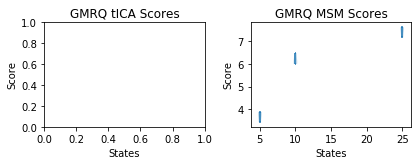

In [22]:
# GMRQ

scores = []
states = [5,10,25]
for i in tqdm.tqdm_notebook(range(len(states))):
    for j in tqdm.tqdm_notebook(range(3),leave=False):
        scores.append([states[i]])
        n_clusters = states[i]
        tica_score = compute_tica_components()
        msm_score = compute_msm()
        scores[-1].append(tica_score)
        scores[-1].append(msm_score)
       # scores[i].append(ContiniousTimeMSM.score(sequences=sequences))
        
scores = np.asarray(scores)

fig = plt.figure()
ax1 = fig.add_subplot(221)
tICY=[[scores[x][1] for x in range(len(scores)) if scores[x][0] == states[y]] for y in range(len(states))]
#ax1.violinplot(dataset=tICY,positions=states)
#ax1.violinplot(X,tICY)
ax1.set_xlabel('States')
ax1.set_ylabel('Score')
ax1.title.set_text('GMRQ tICA Scores')

ax2 = fig.add_subplot(222)
MSMY=[[scores[x][2] for x in range(len(scores)) if scores[x][0] == states[y]] for y in range(len(states))]
ax2.violinplot(dataset=MSMY,positions=states)
ax2.set_xlabel('States')
ax2.set_ylabel('Score')
ax2.title.set_text('GMRQ MSM Scores')

#ax3 = fig.add_subplot(223)
#ax3.violinplot(X,CTMSMY)
#ax3.set_xlabel('States')
#ax3.set_ylabel('Score')
#ax3.title.set_text('GMRQ CTMSM Scores')

fig.tight_layout()
fig.show()

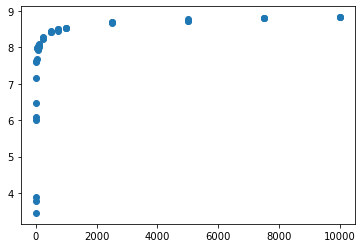

In [30]:
x = [5,5,5,10,10,10,25,25,25,50,50,50,75,75,75,100,100,100,250,250,250,500,500,500,750,750,750,1000,1000,1000,2500,2500,2500,5000,5000,5000,7500,7500,7500,10000,10000,10000]
y = [3.439,3.780,3.885,6.478,5.995,6.092,7.167,7.594,7.617,7.985,7.689,7.997,7.951,7.941,8.047,8.072,8.021,8.108,8.241,8.255,8.283,8.431,8.434,8.464,8.464,8.503,8.499,8.544,8.544,8.525,8.689,8.668,8.701,8.733,8.771,8.726,8.813, 8.800, 8.811, 8.842, 8.845, 8.827]
plt.scatter(x,y)

In [62]:
u_kn, N_k = compute_ukn()
mbar = MBAR(u_kn,N_k,verbose=True)
bin_min = 0.0
bin_max = 1.0 # these are distances?
dx=(bin_max-bin_min)/n_clusters
pmf_distances=np.arange(bin_min,bin_max+dx,dx)
nbins = len(pmf_distances)
########################################################
distance = np.load('distance_99_100.npy')
dis = []
for i in range(len(distance)):
    for j in distance[i]:
        dis.append(j)
dis = np.array(dis)
reshape_dis = dis.reshape(1,u_kn.shape[1])
K = u_kn.shape[0]
nsnaps = distance.shape[-1]
N_k = np.array(K*[nsnaps])
u_kn -= u_kn.min()
bin_kn = np.zeros(reshape_dis.shape,np.int64)
G=[]
mbar = MBAR(u_kn, N_k, verbose=True)
for j in range(2):
    print j
    (f_i, df_i) = mbar.computePMF(u_kn[j], bin_kn, nbins)
    G.append(f_i)
    print f_i, df_i
    fout = open('mbar_%d_sub.dat'%(j),'w')
    fout.write('# distance (nm)\tf (kT)\tdf (kT)\n')
    for i in range(nbins):
        fout.write("%8.4f\t%8.4f\t%8.4f\n" % (pmf_distances[i], f_i[i], df_i[i]) )
    fout.close()
    print 'Wrote'
np.save('raw_G.npy',G)
###############################################

K (total states) = 21, total samples = 137604
N_k = 
[6917 6450 7230 7359 7052 7166 7027 6917 6990 6735 6852 6738 6852 6892 6237
 7090 6871 7155 6711 6363    0]
There are 20 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
Final dimensionless free energies
f_k = 
[  0.          13.96688891  26.23346079  36.88345144  45.95602291
  53.38560619  59.11469852  63.26850613  66.00361937  67.39679509
  67.49070557  66.33976738  64.01382604  60.57926592  56.08753269
  50.57681633  44.07703701  36.61032038  28.18335286  18.76481094
  43.003483  ]
MBAR initialization complete.


In [44]:
################ subsample / autocorrelation #################

from pymbar.timeseries import detectEquilibration
from pymbar.timeseries import statisticalInefficiency

#%ls tram/umbrella_distances/

print('RUN\tAvgSteps\tEquilSteps\tStatIneff\tnUncSamples\tAutocorrelation')
for k in range(K):
    t_k, g_k, Nunc_k, autocorr = [],[],[],[]
    k_distances = np.loadtxt('tram/umbrella_distances/run_%d_dists.dat'%k)
    for l in range(100):
        A_t = np.asarray([x[2] for x in k_distances if x[1] == l])
        if A_t.size != 0:
            autocorr.append(statisticalInefficiency(A_t,A_t))
            indices = detectEquilibration(A_t) # [t, g, Neff_max]
            t_k.append(indices[0])
            g_k.append(indices[1])
            Nunc_k.append(indices[2])
    
    print('%d\t%d\t\t%.3f\t\t%.3f\t\t%d\t\t%.3f'%(k,len(k_distances)/100,np.mean(t_k),np.mean(g_k),np.mean(Nunc_k),np.mean(autocorr)))
                            


RUN	AvgSteps	EquilSteps	StatIneff	nUncSamples	Autocorrelation
0	3458		2.979		1.054		46		1.049
1	3225		0.340		1.032		49		1.027
2	3615		1.926		1.218		42		1.272
3	3679		2.691		1.051		46		1.016
4	3526		1.213		1.157		45		1.107
5	3583		3.957		1.083		44		1.138
6	3513		2.043		1.089		46		1.161
7	3458		4.309		1.175		41		1.361
8	3495		11.511		1.255		33		1.353
9	3367		4.649		1.282		38		1.206
10	3426		14.489		1.571		25		1.724
11	3369		1.723		1.095		46		1.091
12	3426		2.266		1.162		43		1.056
13	3446		4.170		1.081		44		1.336
14	3118		3.521		1.251		39		1.113
15	3545		7.394		1.446		33		1.731
16	3435		4.723		1.385		37		1.192
17	3577		2.181		1.153		44		1.120
18	3355		3.468		1.319		39		1.283
19	3181		4.085		1.236		40		1.111


In [58]:
# GMRQ for state decomposition
# states excluded because of ergotic trimming (if i > j but j !> i, j gets lumped to i)
# d tram can be faster if you calculate free energies first with MBAR and use those as biases
# use state index as bin index for pmf, you will have a pmf for each ensemble, the bias is the pmf
# pmf === free energies
#vpyemma has a built-in function for bias with estimate_umbrella_sampling
# don't add extra sample, add extra ensemble with no bias for K=k
# for its error bars do split into a few clones at a time (same amounts of data tho)

In [ ]:
import pyemma, glob
import numpy as np
project_title = 'PROJ14086'
feature_files = []
for i in range(runs):
    feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
features = [ np.load(filename) for filename in feature_files]

tica = pyemma.coordinates.tica(features, lag=5, dim=4)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
active_count, active_state = 0,0

while [active_count, active_state] != [1.0,1.0]:
    clusters = pyemma.coordinates.cluster_kmeans(tica_output, k=500, max_iter=1000, stride=1)
    dt = md_time_step*stride*1000
    its = pyemma.msm.its(clusters.dtrajs, lags=150, nits=8, errors='bayes')
    pyemma.plots.plot_implied_timescales(its, units='ps', dt=dt)
    msm_obj = pyemma.msm.bayesian_markov_model(clusters.dtrajs, lag=35, dt_traj='%f ps'%dt)
    active_count, active_state = msm_obj.active_count_fraction, msm_obj.active_state_fraction
    print(msm_obj.active_count_fraction)
    print(msm_obj.active_state_fraction)
msm_obj.save('%s/msm.h5'%project_title)


0.9993951457698694
0.994


0.9995930980633667
0.998


0.9995711033640893
0.998


0.999373151070592
0.996


0.9996810768604766
0.998


0.9993951457698694
0.996


0.9995051192662568
0.998


0.9995161166158956
0.998


0.9994721272173406
0.998


17-09-19 17:30:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[56] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:30:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[57] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:30:38 pyemma.msm.estimators.bayesian_msm.BayesianMSM[58] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:30:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[59] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:30:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[60] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:30:39 pyemma.msm.estimators.bayesian_msm.BayesianMSM[61] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:31:13 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[53] WARNING  Estimation has failed at lagtimes: [ 27 

0.9995930980633667
0.998


17-09-19 17:33:27 pyemma.msm.estimators.bayesian_msm.BayesianMSM[61] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:34:14 pyemma.msm.estimators.bayesian_msm.BayesianMSM[62] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:34:15 pyemma.msm.estimators.bayesian_msm.BayesianMSM[63] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:34:35 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[58] WARNING  Estimation has failed at lagtimes: [ 27 140 150]. Details:
['Error at lag time 27: [Errno 12] Cannot allocate memory',
 'Error at lag time 140: [Errno 12] Cannot allocate memory',
 'Error at lag time 150: [Errno 12] Cannot allocate memory']
17-09-19 17:34:43 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[58] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


0.9993511563713146
0.994


17-09-19 17:36:42 pyemma.msm.estimators.bayesian_msm.BayesianMSM[66] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:36:42 pyemma.msm.estimators.bayesian_msm.BayesianMSM[67] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:36:42 pyemma.msm.estimators.bayesian_msm.BayesianMSM[68] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:36:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[69] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:36:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[70] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:36:43 pyemma.msm.estimators.bayesian_msm.BayesianMSM[71] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:37:17 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[63] WARNING  Estimation has failed at lagtimes: [ 27 

0.9995930980633667
0.998


17-09-19 17:39:19 pyemma.msm.estimators.bayesian_msm.BayesianMSM[71] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:39:27 pyemma.msm.estimators.bayesian_msm.BayesianMSM[71] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:39:27 pyemma.msm.estimators.bayesian_msm.BayesianMSM[72] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:39:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[73] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:39:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[74] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:39:28 pyemma.msm.estimators.bayesian_msm.BayesianMSM[75] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:40:00 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[68] WARNING  Estimation has failed at lagtimes: [ 18 

0.9995711033640893
0.998


17-09-19 17:41:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[76] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:41:59 pyemma.msm.estimators.bayesian_msm.BayesianMSM[77] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:42:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[76] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:42:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[78] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:42:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[77] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:42:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[78] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:42:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[79] WARNING  Ignored error during estimation: [Errno 12] Cannot a

0.9996040954130054
0.998


17-09-19 17:44:23 pyemma.msm.estimators.bayesian_msm.BayesianMSM[81] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:23 pyemma.msm.estimators.bayesian_msm.BayesianMSM[82] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:23 pyemma.msm.estimators.bayesian_msm.BayesianMSM[83] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[81] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[84] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[85] WARNING  Ignored error during estimation: [Errno 12] Cannot allocate memory
17-09-19 17:44:24 pyemma.msm.estimators.bayesian_msm.BayesianMSM[82] WARNING  Ignored error during estimation: [Errno 12] Cannot a

Exception in thread Thread-166:
Traceback (most recent call last):
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/multiprocess/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/multiprocess/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/multiprocess/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/multiprocess/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/site-packages/multiprocess/context.

  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/pool.py", line 130, in worker
    put((job, i, (False, wrapped)))
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/matt/packages/conda/envs/msm/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [8]:
import tmap as tm
from faerun import Faerun
import numpy as np
from annoy import AnnoyIndex
from scipy.spatial.distance import cosine as cosine_distance

tica_file = project_title + '/tica/' + 'tica_coords-lag_%d-comp_%d.npy' %(tica_lagtime, n_components)
tica_coordinates = np.load(tica_file, allow_pickle=True)
data = np.concatenate(tica_coordinates, axis=0)[0:1000]

print(np.shape(data))
d = len(data[0])

sources = []
for i, e in enumerate(data):
    sources.extend([i] * len(e))

# Initialize a new Annoy object and index it using 10 trees
annoy = AnnoyIndex(d, metric="angular")
for i, v in enumerate(data):
    annoy.add_item(i, v)
annoy.build(8)

# Create the k-nearest neighbor graph (k = 10)
edge_list = []
for i in range(len(data)):
    for j in annoy.get_nns_by_item(i, 8):
        edge_list.append((i, j, cosine_distance(data[i], data[j])))

    # Compute the layout from the edge list
    x, y, s, t, _ = tm.layout_from_edge_list(len(data), edge_list)

    legend_labels = ['tic%d' for d in range(8)]

    # Create the plot
    faerun = Faerun(
        view="front",
        coords=False,
        legend_title="RNA Flow Cytometry: evaluation of detection sensitivity in low abundant intracellular RNA ",
    )
    faerun.add_scatter(
        "CYTO",
        {"x": x, "y": y, "c": sources, "labels": sources},
        point_scale=1.0,
        max_point_size=10,
        shader="smoothCircle",
        colormap="Set1",
        has_legend=True,
        categorical=True,
        legend_labels=legend_labels,
        legend_title="Cell Types",
    )
    faerun.add_tree(
        "CYTO_tree", {"from": s, "to": t}, point_helper="CYTO", color="#222222"
    )

    faerun.plot("cyto")


(1000, 8)


ValueError: too many values to unpack (expected 2)

In [67]:
project_title = 'PROJ14102'
feature_files = []
for i in range(runs):
    feature_files += sorted(glob.glob(project_title + '/features/' + "P*R%d_*npy"%i))
features = [ np.load(filename) for filename in feature_files]
print(feature_files)

['PROJ14102/features/P14102_R0_C0.npy', 'PROJ14102/features/P14102_R0_C1.npy', 'PROJ14102/features/P14102_R0_C10.npy', 'PROJ14102/features/P14102_R0_C11.npy', 'PROJ14102/features/P14102_R0_C12.npy', 'PROJ14102/features/P14102_R0_C13.npy', 'PROJ14102/features/P14102_R0_C14.npy', 'PROJ14102/features/P14102_R0_C15.npy', 'PROJ14102/features/P14102_R0_C16.npy', 'PROJ14102/features/P14102_R0_C17.npy', 'PROJ14102/features/P14102_R0_C18.npy', 'PROJ14102/features/P14102_R0_C19.npy', 'PROJ14102/features/P14102_R0_C2.npy', 'PROJ14102/features/P14102_R0_C20.npy', 'PROJ14102/features/P14102_R0_C21.npy', 'PROJ14102/features/P14102_R0_C22.npy', 'PROJ14102/features/P14102_R0_C23.npy', 'PROJ14102/features/P14102_R0_C24.npy', 'PROJ14102/features/P14102_R0_C28.npy', 'PROJ14102/features/P14102_R0_C29.npy', 'PROJ14102/features/P14102_R0_C3.npy', 'PROJ14102/features/P14102_R0_C32.npy', 'PROJ14102/features/P14102_R0_C34.npy', 'PROJ14102/features/P14102_R0_C35.npy', 'PROJ14102/features/P14102_R0_C36.npy', 'PR

In [43]:
a = np.load(project_title + '/dhdl/P14090_R0_C0.dat.npy')
b = np.load(project_title + '/features/P14090_R0_C0.npy')
c = md.load(project_title + '/traj_data/RUN0/P14090_R0_C0.xtc',top=structure_file)
print(np.shape(a))
print(np.shape(b))
print(len(c))

(265234, 22)
(529, 77)
13261


In [21]:
feature_files, ensemble_indices = [],[]
for i in range(runs):
    run_feature_files = sorted(glob.glob(project_title + '/features/P*R%d_*npy'%i))
    ensemble_indices.append(len(run_feature_files))
    feature_files += run_feature_files
features = [ np.load(filename) for filename in feature_files]
print(len(ensemble_indices))
print(ensemble_indices)
features_by_umbrella = [[]]*10
features_by_lambda = [[]]*20
for i in range(200):
    for j in range(len(features_by_umbrella)):
        if i%10 == j:
            print()
            features_by_umbrella[j].append(features[i])
    for j in range(len(features_by_lambda)):
        if int(i/len(features_by_lambda)) == j:
            features_by_lambda[j].append(features[i])
print(len(features_by_umbrella))
print(np.shape(features_by_umbrella[0]))
print(len(features_by_lambda))
print(np.shape(features_by_lambda[0]))
print(features_by_lambda[0][0]) # ensemble trajectory frame feature

203
[2, 3, 4, 3, 2, 3, 4, 3, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 2, 3, 2, 3, 2, 2, 3, 4, 3, 2, 0, 2, 3, 2, 3, 3, 2, 3, 4, 3, 1, 2, 4, 2, 1, 3, 2, 4, 3, 1, 4, 1, 2, 3, 3, 3, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 1, 1, 2, 2, 3, 4, 2, 3, 4, 2, 3, 1, 3, 1, 3, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 3, 2, 1, 2, 2, 1, 3, 3, 2, 2, 3, 3, 3, 2, 3, 1, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 1, 0, 2, 2, 3, 2, 3, 3, 3, 1, 2, 3, 1, 1, 2, 3, 1, 2, 1, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 1, 3, 3, 1, 2, 3, 2, 2, 1]








































































































































































































10
(200,)
20
(200,)
[[ 1.70941091  1.83016229  1.71850574 ...,  1.52012813  1.37342119
   1.63864958]
 [ 1.66800153  1.61979604  1.56380558 ...,  1.48251617  1.36838055
   1.64472866]
 [

0 1.53341
10 1.73951
20 1.60977
30 1.62428
40 1.68473
50 1.97551
60 1.56098
70 2.01904
80 1.97359
90 1.71605
100 1.82296
110 1.54563
120 1.77554
130 1.52608
140 1.7158
150 1.67849
160 1.53367
170 1.96327
180 1.57143
190 1.54738
200 1.62062
210 1.5489
220 1.48193
230 1.43068
240 1.51583
250 1.85819
260 1.88061
270 1.81235
280 1.44957
290 1.65898
300 1.46102
310 1.44948
320 1.7053
330 1.65966
340 1.61294
350 1.71835
360 1.86733
370 1.27863
380 1.62723
390 1.7731
400 1.62906
410 1.43822
420 1.50691
430 1.52185
440 1.62174
450 1.7969
460 1.95711
470 2.00482
480 2.2851
490 1.98354
500 1.66941
510 1.89339
520 2.0025
0 1.46126
10 1.58245
20 1.67737
30 1.60083
40 1.56983
50 1.48758
60 1.60039
70 1.58013
80 1.59781
90 1.54679
100 1.39807
110 1.50127
0 1.58828
10 1.40662
20 1.55286
30 1.71768
40 1.65433
50 1.67941
60 1.62187
70 1.53726
80 1.94033
90 1.48631
100 1.60691
110 1.49886
120 1.46535
130 1.63686
140 1.70219
150 1.57884
160 1.39945
170 1.8771
180 2.04206
190 1.93413
200 1.91837
210 1.644

20 1.68618
30 1.59856
40 1.62159
50 1.69842
60 1.35339
70 1.54015
80 1.45045
90 1.67757
100 1.64457
110 1.47349
120 1.52036
130 1.55874
140 1.56933
150 1.55141
160 1.60066
0 1.42011
10 1.47569
20 1.59426
30 1.52858
40 1.55988
50 1.62367
60 1.65293
70 1.749
80 1.67101
90 1.72903
100 1.68457
110 1.51898
120 1.62628
130 1.69655
140 1.53934
150 1.50981
160 1.54851
170 1.46618
0 1.5167
10 1.46937
20 1.46157
30 1.51401
40 1.60437
50 1.51822
60 1.53929
70 1.50106
80 1.63581
90 1.56723
100 1.64529
110 1.60304
120 1.57411
130 1.72652
140 1.75435
150 1.71959
160 1.63575
170 1.38257
180 1.7522
190 1.57109
200 1.59029
210 1.69233
0 1.58513
10 1.48869
20 1.39346
30 1.44114
40 1.43552
50 1.62002
60 1.5796
70 1.54456
80 1.79957
90 1.63547
100 1.75159
0 1.47527
10 1.68119
20 1.52385
30 1.65098
40 1.67691
50 1.5453
60 1.68128
70 1.64288
0 1.4955
10 1.61416
20 1.54931
30 1.53704
40 1.60089
50 1.51833
60 1.58379
70 1.47901
80 1.52418
90 1.42049
100 1.95677
110 1.72109
120 1.46546
130 1.51392
140 1.54408


50 1.53741
60 1.51275
70 1.49102
80 1.47039
90 1.51589
100 1.5221
110 1.55909
120 1.62699
130 1.61842
140 1.51975
150 1.68448
160 1.69355
170 1.83309
180 1.4946
190 2.59306
200 3.36223
210 2.59676
220 5.1847
230 4.49434
240 3.25396
250 3.61704
260 3.56707
270 3.17546
280 5.23672
290 4.57129
300 2.87489
310 3.30719
320 3.72497
330 3.42691
340 2.49847
350 3.92175
360 2.98109
0 1.45579
10 1.48316
20 1.46409
30 1.48773
40 1.49314
50 1.54243
60 1.86649
70 1.79865
80 1.59018
90 1.69754
100 1.47563
110 1.48473
120 1.5959
130 1.61902
140 1.64288
150 1.65085
160 1.59048
170 1.53091
180 1.50309
190 1.84268
200 1.42024
210 1.62385
220 1.48966
230 1.52284
240 1.64686
250 1.61484
260 1.50519
270 1.40283
280 1.45733
290 1.50785
300 1.62028
310 1.57977
0 1.58741
10 1.51108
20 1.57011
30 1.5605
40 1.64012
50 1.49433
60 1.52759
70 1.7382
80 1.55496
90 1.56931
100 1.51871
110 1.56859
120 1.48659
130 1.55122
140 1.46089
150 1.65045
0 1.47497
10 1.51249
20 1.53772
30 1.42825
40 1.4298
50 1.58867
60 1.5213

210 1.64537
220 1.64239
230 1.52458
240 1.56676
250 1.59827
260 1.57754
0 1.5262
10 1.48825
20 1.46703
30 1.52705
40 1.51972
50 1.48083
60 1.43187
70 1.4547
80 1.49726
90 1.47487
100 1.45538
0 1.47687
10 1.51568
20 1.47531
30 1.46948
40 1.48252
50 1.47902
60 1.48012
70 1.48366
80 1.54277
90 1.45114
100 1.49045
110 1.522
120 1.70151
130 1.54837
140 1.67582
150 1.50261
160 1.63012
170 1.66958
0 1.41205
10 1.49323
20 1.48387
30 1.48058
40 1.4466
50 1.57212
60 1.4411
70 1.48317
80 1.49926
90 1.51307
100 1.51485
110 1.48569
120 1.5984
130 1.70659
140 1.51166
150 1.55373
160 1.57382
170 1.72783
180 1.48717
190 1.59005
200 1.57277
210 1.5565
220 1.5355
230 1.60774
240 1.65845
250 1.7167
260 1.67129
270 1.47705
280 1.57296
290 1.66102
300 1.517
310 1.63304
320 1.57278
330 1.59838
340 1.74643
350 1.5752
360 1.53077
370 1.48169
380 1.53994
390 1.43939
400 1.506
0 1.44718
10 1.43692
20 1.51316
30 1.54885
40 1.46319
50 1.45192
60 1.4851
70 1.46956
80 1.46132
90 1.52497
100 1.48733
110 1.44629
120 

10 1.50642
20 1.47838
30 1.53357
40 1.50649
50 1.51713
60 1.56379
70 1.62376
80 1.5498
90 1.45947
100 1.57686
110 1.55121
0 1.50195
10 1.46252
20 1.4767
30 1.49248
40 1.44511
50 1.48038
60 1.40408
70 1.57278
80 1.50601
90 1.5294
100 1.53751
110 1.50223
120 1.46577
130 1.54442
140 1.5169
150 1.44868
160 1.48234
170 1.49979
180 1.63362
190 1.40363
200 1.74859
210 1.72909
220 1.7748
230 1.6647
240 1.68641
250 1.6432
260 1.68607
270 1.66684
280 1.7419
290 1.71893
300 1.76356
310 1.61381
320 1.58292
0 1.46289
10 1.37382
20 1.46501
30 1.48633
40 1.59799
50 1.41812
60 1.43821
70 1.42718
80 1.47173
90 1.46396
100 1.46138
110 1.55449
0 1.47016
10 1.44705
20 1.518
30 1.50243
40 1.62785
50 1.54116
60 1.54552
70 1.5404
80 1.53812
90 1.47843
100 1.44721
110 1.46233
120 1.40202
0 1.55414
10 1.45052
20 1.50681
30 1.49593
40 1.46648
50 1.47405
60 1.39111
70 1.44669
80 1.51041
90 1.52506
0 1.44994
10 1.50783
20 1.61588
30 1.82295
40 1.73687
50 1.56975
60 1.42223
70 1.61333
80 1.44842
90 1.4362
100 1.51

0 1.53341
10 1.73951
20 1.60977
30 1.62428
40 1.68473
50 1.97551
60 1.56098
70 2.01904
80 1.97359
90 1.71605
100 1.82296
110 1.54563
120 1.77554
130 1.52608
140 1.7158
150 1.67849
160 1.53367
170 1.96327
180 1.57143
190 1.54738
200 1.62062
210 1.5489
220 1.48193
230 1.43068
240 1.51583
250 1.85819
260 1.88061
270 1.81235
280 1.44957
290 1.65898
300 1.46102
310 1.44948
320 1.7053
330 1.65966
340 1.61294
350 1.71835
360 1.86733
370 1.27863
380 1.62723
390 1.7731
400 1.62906
410 1.43822
420 1.50691
430 1.52185
440 1.62174
450 1.7969
460 1.95711
470 2.00482
480 2.2851
490 1.98354
500 1.66941
510 1.89339
520 2.0025
0 1.46126
10 1.58245
20 1.67737
30 1.60083
40 1.56983
50 1.48758
60 1.60039
70 1.58013
80 1.59781
90 1.54679
100 1.39807
110 1.50127
0 1.58828
10 1.40662
20 1.55286
30 1.71768
40 1.65433
50 1.67941
60 1.62187
70 1.53726
80 1.94033
90 1.48631
100 1.60691
110 1.49886
120 1.46535
130 1.63686
140 1.70219
150 1.57884
160 1.39945
170 1.8771
180 2.04206
190 1.93413
200 1.91837
210 1.644

50 1.51833
60 1.58379
70 1.47901
80 1.52418
90 1.42049
100 1.95677
110 1.72109
120 1.46546
130 1.51392
140 1.54408
150 1.54773
160 3.79575
170 3.99059
180 4.88153
190 3.23698
200 5.20912
210 2.66092
220 3.4748
0 1.53815
10 1.59674
20 1.67363
30 1.46693
40 1.48731
50 1.54428
60 1.44166
70 1.52855
80 1.45147
90 1.51566
0 1.49678
10 1.44038
20 1.60715
30 1.58571
40 1.50999
50 1.46111
60 1.83802
70 2.02797
80 1.50591
90 1.4528
0 1.56292
10 1.57199
20 1.63153
30 1.56895
40 1.65239
50 1.55026
60 1.47931
70 1.6648
80 2.04948
90 1.53284
0 1.5236
10 1.54809
20 1.44731
30 1.4799
40 1.51339
50 1.49373
60 1.47224
70 1.41489
80 1.40427
90 1.63656
100 1.54163
110 1.63683
120 1.58339
130 1.48785
140 1.5353
150 1.68826
160 1.48076
170 1.56237
180 1.75918
190 1.50278
200 1.43228
210 1.45642
220 1.5339
230 1.50999
240 1.44582
0 1.48057
10 1.45159
20 1.44394
30 1.62792
40 1.62282
50 1.66576
60 2.12453
70 1.8808
80 1.76542
90 1.62595
100 1.48579
110 1.45916
120 1.6219
130 1.54903
140 1.80402
150 1.58329
1

360 2.98109
0 1.45579
10 1.48316
20 1.46409
30 1.48773
40 1.49314
50 1.54243
60 1.86649
70 1.79865
80 1.59018
90 1.69754
100 1.47563
110 1.48473
120 1.5959
130 1.61902
140 1.64288
150 1.65085
160 1.59048
170 1.53091
180 1.50309
190 1.84268
200 1.42024
210 1.62385
220 1.48966
230 1.52284
240 1.64686
250 1.61484
260 1.50519
270 1.40283
280 1.45733
290 1.50785
300 1.62028
310 1.57977
0 1.58741
10 1.51108
20 1.57011
30 1.5605
40 1.64012
50 1.49433
60 1.52759
70 1.7382
80 1.55496
90 1.56931
100 1.51871
110 1.56859
120 1.48659
130 1.55122
140 1.46089
150 1.65045
0 1.47497
10 1.51249
20 1.53772
30 1.42825
40 1.4298
50 1.58867
60 1.52139
70 1.50281
80 1.47831
90 1.45859
100 1.5404
110 1.52677
0 1.5194
10 1.56277
20 1.57114
30 1.46107
40 1.5514
50 1.43272
60 1.50738
70 1.62897
80 1.5683
90 1.49935
100 1.59487
110 1.93661
120 1.99431
130 1.98122
140 1.57717
150 1.55512
160 1.69221
170 1.63284
180 1.58078
190 1.59706
200 1.54738
210 1.51077
220 1.50778
230 1.55195
240 1.64295
250 1.54653
260 2.02

70 1.48317
80 1.49926
90 1.51307
100 1.51485
110 1.48569
120 1.5984
130 1.70659
140 1.51166
150 1.55373
160 1.57382
170 1.72783
180 1.48717
190 1.59005
200 1.57277
210 1.5565
220 1.5355
230 1.60774
240 1.65845
250 1.7167
260 1.67129
270 1.47705
280 1.57296
290 1.66102
300 1.517
310 1.63304
320 1.57278
330 1.59838
340 1.74643
350 1.5752
360 1.53077
370 1.48169
380 1.53994
390 1.43939
400 1.506
0 1.44718
10 1.43692
20 1.51316
30 1.54885
40 1.46319
50 1.45192
60 1.4851
70 1.46956
80 1.46132
90 1.52497
100 1.48733
110 1.44629
120 1.50786
130 1.58602
140 1.48093
0 1.45266
10 1.70434
20 1.46277
30 1.72195
40 1.55832
50 1.50516
60 1.56283
70 1.52727
80 1.56528
90 1.61676
100 1.48729
110 1.63875
0 1.47247
10 1.43374
20 1.48082
30 1.51193
40 1.52219
50 1.48613
60 1.52875
70 1.63854
80 1.58635
0 1.41593
10 1.48056
20 1.46303
30 1.53213
40 1.58945
50 1.51362
60 1.47817
70 1.48786
80 1.711
90 1.4648
100 1.45312
110 1.48014
120 1.55688
130 1.49298
140 1.55052
0 1.47654
10 1.57695
20 1.66125
30 1.67

180 1.63362
190 1.40363
200 1.74859
210 1.72909
220 1.7748
230 1.6647
240 1.68641
250 1.6432
260 1.68607
270 1.66684
280 1.7419
290 1.71893
300 1.76356
310 1.61381
320 1.58292
0 1.46289
10 1.37382
20 1.46501
30 1.48633
40 1.59799
50 1.41812
60 1.43821
70 1.42718
80 1.47173
90 1.46396
100 1.46138
110 1.55449
0 1.47016
10 1.44705
20 1.518
30 1.50243
40 1.62785
50 1.54116
60 1.54552
70 1.5404
80 1.53812
90 1.47843
100 1.44721
110 1.46233
120 1.40202
0 1.55414
10 1.45052
20 1.50681
30 1.49593
40 1.46648
50 1.47405
60 1.39111
70 1.44669
80 1.51041
90 1.52506
0 1.44994
10 1.50783
20 1.61588
30 1.82295
40 1.73687
50 1.56975
60 1.42223
70 1.61333
80 1.44842
90 1.4362
100 1.51388
110 1.45927
120 1.54481
130 1.53547
140 1.64923
0 1.48715
10 1.56193
20 1.44439
30 1.53179
40 1.53414
50 1.49024
60 1.51386
70 1.59591
80 1.4912
90 1.48119
100 1.47577
110 1.53051
120 1.50934
130 1.5012
140 1.52491
150 1.54169
160 1.50508
170 1.44423
180 1.45149
190 1.52658
200 1.44245
210 1.50463
220 1.53196
230 1.574

120 1.53278
130 1.69408
140 1.44062
150 1.85647
160 2.09654
170 1.49586
180 1.57726
0 1.5287
10 1.58754
20 1.50187
30 1.80392
40 1.54996
50 1.48081
60 1.70862
70 1.71149
80 1.60848
90 1.78257
100 1.55027
110 1.59345
120 1.58182
0 1.60709
10 1.51373
20 1.5357
30 1.55172
40 1.54489
50 1.5288
60 1.52198
70 1.47065
80 1.4656
90 1.73929
100 1.70361
110 1.7513
120 1.5492
130 1.34511
140 1.60893
150 1.47113
160 1.63285
170 1.67671
180 1.62958
190 1.61942
200 1.78578
210 1.80695
220 1.60916
0 1.45891
10 1.93588
20 1.53093
30 1.43194
40 1.46054
50 1.38644
60 1.46268
70 1.72318
80 1.53046
90 1.51737
0 1.54077
10 1.62038
20 1.70204
30 1.63261
40 1.64047
50 1.54807
60 1.47463
70 1.56068
80 1.5758
90 1.58019
100 1.63465
110 1.5988
120 1.44877
130 1.45588
140 1.52039
150 1.63859
160 1.65558
170 1.62247
180 1.54769
190 1.69836
200 1.5137
210 1.91555
220 1.82975
230 1.77596
240 1.46192
250 1.44787
260 1.44223
270 1.49443
280 1.65089
290 1.57969
300 1.55914
310 1.64707
320 1.62658
330 1.58076
340 1.598

100 1.54163
110 1.63683
120 1.58339
130 1.48785
140 1.5353
150 1.68826
160 1.48076
170 1.56237
180 1.75918
190 1.50278
200 1.43228
210 1.45642
220 1.5339
230 1.50999
240 1.44582
0 1.48057
10 1.45159
20 1.44394
30 1.62792
40 1.62282
50 1.66576
60 2.12453
70 1.8808
80 1.76542
90 1.62595
100 1.48579
110 1.45916
120 1.6219
130 1.54903
140 1.80402
150 1.58329
160 1.59814
170 1.66882
180 1.64394
190 1.65406
200 1.52892
210 1.49148
220 1.63977
230 1.58612
240 1.53376
250 1.70669
260 1.57947
270 1.70587
280 1.69929
290 1.57437
0 1.56318
10 1.48794
20 1.64976
30 1.56192
40 1.55421
50 1.54824
60 1.44287
70 1.45765
80 1.48131
90 1.56631
100 1.48482
110 1.57717
120 1.5079
130 1.99283
140 1.86442
150 1.70743
160 1.94556
170 1.52748
180 1.42483
190 1.47204
200 1.50153
210 1.47524
0 1.46681
10 1.72578
20 1.64919
30 1.80621
40 1.58067
50 1.58725
60 1.63539
70 1.58998
80 1.55964
90 1.86603
100 1.86591
110 2.1234
0 1.53655
10 1.64641
20 1.62231
30 1.49695
40 1.67311
50 1.79265
60 1.89048
70 1.4613
80 1.

210 1.51077
220 1.50778
230 1.55195
240 1.64295
250 1.54653
260 2.02929
270 2.00571
0 1.55832
10 1.57294
20 1.55105
30 1.46842
40 1.44485
50 1.42664
60 1.43515
70 1.53288
80 1.58288
90 1.47062
0 1.44057
10 1.48788
20 1.48112
30 1.48463
40 1.58402
50 1.48885
60 1.46133
70 1.93578
80 1.52959
90 1.63217
100 1.70173
110 1.64434
120 1.99935
130 1.89869
140 1.99916
150 1.85656
160 1.5741
170 1.91085
180 1.89169
190 1.61353
200 1.45946
210 1.81011
0 1.51288
10 1.4605
20 1.48179
30 1.48818
40 1.50735
50 1.54538
60 1.62431
70 1.62646
80 1.73357
90 1.64468
100 1.62366
110 1.60997
120 1.68219
130 1.66513
140 1.54745
150 1.53819
160 1.61563
170 1.58841
180 1.57306
190 1.65747
0 1.52117
10 1.53193
20 1.51485
30 1.56558
40 1.47791
50 1.51011
60 1.65089
70 1.58904
0 1.4757
10 1.48818
20 1.65337
30 1.55514
40 1.49114
50 1.63221
60 1.56687
70 1.55799
80 1.58805
90 1.59829
100 1.42576
110 1.45915
120 1.51985
130 1.4984
140 1.45467
150 1.56611
160 1.41848
170 1.45196
180 1.75453
190 1.48531
200 1.51737
2

260 1.67129
270 1.47705
280 1.57296
290 1.66102
300 1.517
310 1.63304
320 1.57278
330 1.59838
340 1.74643
350 1.5752
360 1.53077
370 1.48169
380 1.53994
390 1.43939
400 1.506
0 1.44718
10 1.43692
20 1.51316
30 1.54885
40 1.46319
50 1.45192
60 1.4851
70 1.46956
80 1.46132
90 1.52497
100 1.48733
110 1.44629
120 1.50786
130 1.58602
140 1.48093
0 1.45266
10 1.70434
20 1.46277
30 1.72195
40 1.55832
50 1.50516
60 1.56283
70 1.52727
80 1.56528
90 1.61676
100 1.48729
110 1.63875
0 1.47247
10 1.43374
20 1.48082
30 1.51193
40 1.52219
50 1.48613
60 1.52875
70 1.63854
80 1.58635
0 1.41593
10 1.48056
20 1.46303
30 1.53213
40 1.58945
50 1.51362
60 1.47817
70 1.48786
80 1.711
90 1.4648
100 1.45312
110 1.48014
120 1.55688
130 1.49298
140 1.55052
0 1.47654
10 1.57695
20 1.66125
30 1.67555
40 1.52479
50 1.47962
60 1.46508
70 1.45687
80 1.4905
90 1.51131
100 1.45299
110 1.46858
120 1.6464
130 1.46764
140 1.52592
150 1.53631
160 1.51075
170 1.52811
180 1.43239
190 1.4873
200 1.60979
210 1.82064
220 1.6776

80 1.53812
90 1.47843
100 1.44721
110 1.46233
120 1.40202
0 1.55414
10 1.45052
20 1.50681
30 1.49593
40 1.46648
50 1.47405
60 1.39111
70 1.44669
80 1.51041
90 1.52506
0 1.44994
10 1.50783
20 1.61588
30 1.82295
40 1.73687
50 1.56975
60 1.42223
70 1.61333
80 1.44842
90 1.4362
100 1.51388
110 1.45927
120 1.54481
130 1.53547
140 1.64923
0 1.48715
10 1.56193
20 1.44439
30 1.53179
40 1.53414
50 1.49024
60 1.51386
70 1.59591
80 1.4912
90 1.48119
100 1.47577
110 1.53051
120 1.50934
130 1.5012
140 1.52491
150 1.54169
160 1.50508
170 1.44423
180 1.45149
190 1.52658
200 1.44245
210 1.50463
220 1.53196
230 1.57496
240 1.73536
250 1.73175
260 1.81912
0 1.45811
10 1.41018
20 1.42528
30 1.47046
40 1.52347
50 1.47215
60 1.5039
70 1.45961
80 1.49268
90 1.41775
100 1.49187
110 1.43854
120 1.53513
130 1.46349
140 1.62122
150 1.74934
160 1.68468
170 1.59433
180 1.6546
190 1.53186
200 1.63526
210 1.62038
220 1.43042
230 1.41725
240 1.48798
250 1.50559
260 1.45412
270 1.45469
280 1.47919
290 1.4529
300 1.48

160 2.09654
170 1.49586
180 1.57726
0 1.5287
10 1.58754
20 1.50187
30 1.80392
40 1.54996
50 1.48081
60 1.70862
70 1.71149
80 1.60848
90 1.78257
100 1.55027
110 1.59345
120 1.58182
0 1.60709
10 1.51373
20 1.5357
30 1.55172
40 1.54489
50 1.5288
60 1.52198
70 1.47065
80 1.4656
90 1.73929
100 1.70361
110 1.7513
120 1.5492
130 1.34511
140 1.60893
150 1.47113
160 1.63285
170 1.67671
180 1.62958
190 1.61942
200 1.78578
210 1.80695
220 1.60916
0 1.45891
10 1.93588
20 1.53093
30 1.43194
40 1.46054
50 1.38644
60 1.46268
70 1.72318
80 1.53046
90 1.51737
0 1.54077
10 1.62038
20 1.70204
30 1.63261
40 1.64047
50 1.54807
60 1.47463
70 1.56068
80 1.5758
90 1.58019
100 1.63465
110 1.5988
120 1.44877
130 1.45588
140 1.52039
150 1.63859
160 1.65558
170 1.62247
180 1.54769
190 1.69836
200 1.5137
210 1.91555
220 1.82975
230 1.77596
240 1.46192
250 1.44787
260 1.44223
270 1.49443
280 1.65089
290 1.57969
300 1.55914
310 1.64707
320 1.62658
330 1.58076
340 1.59864
350 1.6745
360 1.76067
370 1.75726
380 1.6287

200 1.43228
210 1.45642
220 1.5339
230 1.50999
240 1.44582
0 1.48057
10 1.45159
20 1.44394
30 1.62792
40 1.62282
50 1.66576
60 2.12453
70 1.8808
80 1.76542
90 1.62595
100 1.48579
110 1.45916
120 1.6219
130 1.54903
140 1.80402
150 1.58329
160 1.59814
170 1.66882
180 1.64394
190 1.65406
200 1.52892
210 1.49148
220 1.63977
230 1.58612
240 1.53376
250 1.70669
260 1.57947
270 1.70587
280 1.69929
290 1.57437
0 1.56318
10 1.48794
20 1.64976
30 1.56192
40 1.55421
50 1.54824
60 1.44287
70 1.45765
80 1.48131
90 1.56631
100 1.48482
110 1.57717
120 1.5079
130 1.99283
140 1.86442
150 1.70743
160 1.94556
170 1.52748
180 1.42483
190 1.47204
200 1.50153
210 1.47524
0 1.46681
10 1.72578
20 1.64919
30 1.80621
40 1.58067
50 1.58725
60 1.63539
70 1.58998
80 1.55964
90 1.86603
100 1.86591
110 2.1234
0 1.53655
10 1.64641
20 1.62231
30 1.49695
40 1.67311
50 1.79265
60 1.89048
70 1.4613
80 1.70153
90 1.40091
100 1.65149
110 1.46365
0 1.42597
10 1.49804
20 1.5288
30 1.628
40 1.49715
50 1.47081
60 1.53646
70 1.

10 1.57294
20 1.55105
30 1.46842
40 1.44485
50 1.42664
60 1.43515
70 1.53288
80 1.58288
90 1.47062
0 1.44057
10 1.48788
20 1.48112
30 1.48463
40 1.58402
50 1.48885
60 1.46133
70 1.93578
80 1.52959
90 1.63217
100 1.70173
110 1.64434
120 1.99935
130 1.89869
140 1.99916
150 1.85656
160 1.5741
170 1.91085
180 1.89169
190 1.61353
200 1.45946
210 1.81011
0 1.51288
10 1.4605
20 1.48179
30 1.48818
40 1.50735
50 1.54538
60 1.62431
70 1.62646
80 1.73357
90 1.64468
100 1.62366
110 1.60997
120 1.68219
130 1.66513
140 1.54745
150 1.53819
160 1.61563
170 1.58841
180 1.57306
190 1.65747
0 1.52117
10 1.53193
20 1.51485
30 1.56558
40 1.47791
50 1.51011
60 1.65089
70 1.58904
0 1.4757
10 1.48818
20 1.65337
30 1.55514
40 1.49114
50 1.63221
60 1.56687
70 1.55799
80 1.58805
90 1.59829
100 1.42576
110 1.45915
120 1.51985
130 1.4984
140 1.45467
150 1.56611
160 1.41848
170 1.45196
180 1.75453
190 1.48531
200 1.51737
210 1.54084
220 1.55123
230 1.67797
240 1.5417
250 1.61368
260 1.61465
270 1.50353
0 1.47584
10

0 1.44718
10 1.43692
20 1.51316
30 1.54885
40 1.46319
50 1.45192
60 1.4851
70 1.46956
80 1.46132
90 1.52497
100 1.48733
110 1.44629
120 1.50786
130 1.58602
140 1.48093
0 1.45266
10 1.70434
20 1.46277
30 1.72195
40 1.55832
50 1.50516
60 1.56283
70 1.52727
80 1.56528
90 1.61676
100 1.48729
110 1.63875
0 1.47247
10 1.43374
20 1.48082
30 1.51193
40 1.52219
50 1.48613
60 1.52875
70 1.63854
80 1.58635
0 1.41593
10 1.48056
20 1.46303
30 1.53213
40 1.58945
50 1.51362
60 1.47817
70 1.48786
80 1.711
90 1.4648
100 1.45312
110 1.48014
120 1.55688
130 1.49298
140 1.55052
0 1.47654
10 1.57695
20 1.66125
30 1.67555
40 1.52479
50 1.47962
60 1.46508
70 1.45687
80 1.4905
90 1.51131
100 1.45299
110 1.46858
120 1.6464
130 1.46764
140 1.52592
150 1.53631
160 1.51075
170 1.52811
180 1.43239
190 1.4873
200 1.60979
210 1.82064
220 1.67768
230 1.70886
240 1.61582
250 1.4724
260 1.89635
270 1.78522
280 1.95916
0 1.51751
10 1.50671
20 1.36472
30 1.56433
40 1.45583
50 1.45095
60 1.51102
70 1.51085
80 1.43431
90 1

10 1.37382
20 1.46501
30 1.48633
40 1.59799
50 1.41812
60 1.43821
70 1.42718
80 1.47173
90 1.46396
100 1.46138
110 1.55449
0 1.47016
10 1.44705
20 1.518
30 1.50243
40 1.62785
50 1.54116
60 1.54552
70 1.5404
80 1.53812
90 1.47843
100 1.44721
110 1.46233
120 1.40202
0 1.55414
10 1.45052
20 1.50681
30 1.49593
40 1.46648
50 1.47405
60 1.39111
70 1.44669
80 1.51041
90 1.52506
0 1.44994
10 1.50783
20 1.61588
30 1.82295
40 1.73687
50 1.56975
60 1.42223
70 1.61333
80 1.44842
90 1.4362
100 1.51388
110 1.45927
120 1.54481
130 1.53547
140 1.64923
0 1.48715
10 1.56193
20 1.44439
30 1.53179
40 1.53414
50 1.49024
60 1.51386
70 1.59591
80 1.4912
90 1.48119
100 1.47577
110 1.53051
120 1.50934
130 1.5012
140 1.52491
150 1.54169
160 1.50508
170 1.44423
180 1.45149
190 1.52658
200 1.44245
210 1.50463
220 1.53196
230 1.57496
240 1.73536
250 1.73175
260 1.81912
0 1.45811
10 1.41018
20 1.42528
30 1.47046
40 1.52347
50 1.47215
60 1.5039
70 1.45961
80 1.49268
90 1.41775
100 1.49187
110 1.43854
120 1.53513
130

50 1.49461
60 1.83292
70 1.58841
80 1.73528
90 1.55097
100 1.85741
110 1.88342
120 1.53278
130 1.69408
140 1.44062
150 1.85647
160 2.09654
170 1.49586
180 1.57726
0 1.5287
10 1.58754
20 1.50187
30 1.80392
40 1.54996
50 1.48081
60 1.70862
70 1.71149
80 1.60848
90 1.78257
100 1.55027
110 1.59345
120 1.58182
0 1.60709
10 1.51373
20 1.5357
30 1.55172
40 1.54489
50 1.5288
60 1.52198
70 1.47065
80 1.4656
90 1.73929
100 1.70361
110 1.7513
120 1.5492
130 1.34511
140 1.60893
150 1.47113
160 1.63285
170 1.67671
180 1.62958
190 1.61942
200 1.78578
210 1.80695
220 1.60916
0 1.45891
10 1.93588
20 1.53093
30 1.43194
40 1.46054
50 1.38644
60 1.46268
70 1.72318
80 1.53046
90 1.51737
0 1.54077
10 1.62038
20 1.70204
30 1.63261
40 1.64047
50 1.54807
60 1.47463
70 1.56068
80 1.5758
90 1.58019
100 1.63465
110 1.5988
120 1.44877
130 1.45588
140 1.52039
150 1.63859
160 1.65558
170 1.62247
180 1.54769
190 1.69836
200 1.5137
210 1.91555
220 1.82975
230 1.77596
240 1.46192
250 1.44787
260 1.44223
270 1.49443
28

150 1.58329
160 1.59814
170 1.66882
180 1.64394
190 1.65406
200 1.52892
210 1.49148
220 1.63977
230 1.58612
240 1.53376
250 1.70669
260 1.57947
270 1.70587
280 1.69929
290 1.57437
0 1.56318
10 1.48794
20 1.64976
30 1.56192
40 1.55421
50 1.54824
60 1.44287
70 1.45765
80 1.48131
90 1.56631
100 1.48482
110 1.57717
120 1.5079
130 1.99283
140 1.86442
150 1.70743
160 1.94556
170 1.52748
180 1.42483
190 1.47204
200 1.50153
210 1.47524
0 1.46681
10 1.72578
20 1.64919
30 1.80621
40 1.58067
50 1.58725
60 1.63539
70 1.58998
80 1.55964
90 1.86603
100 1.86591
110 2.1234
0 1.53655
10 1.64641
20 1.62231
30 1.49695
40 1.67311
50 1.79265
60 1.89048
70 1.4613
80 1.70153
90 1.40091
100 1.65149
110 1.46365
0 1.42597
10 1.49804
20 1.5288
30 1.628
40 1.49715
50 1.47081
60 1.53646
70 1.45238
80 1.42385
90 1.6608
100 1.69282
110 1.91785
120 1.9485
130 1.95519
140 1.64761
150 1.42671
160 1.46358
170 1.62554
180 1.75619
190 1.50801
200 1.49976
210 1.77528
220 1.87883
230 1.93148
240 1.7136
250 1.34612
260 1.621

250 1.54653
260 2.02929
270 2.00571
0 1.55832
10 1.57294
20 1.55105
30 1.46842
40 1.44485
50 1.42664
60 1.43515
70 1.53288
80 1.58288
90 1.47062
0 1.44057
10 1.48788
20 1.48112
30 1.48463
40 1.58402
50 1.48885
60 1.46133
70 1.93578
80 1.52959
90 1.63217
100 1.70173
110 1.64434
120 1.99935
130 1.89869
140 1.99916
150 1.85656
160 1.5741
170 1.91085
180 1.89169
190 1.61353
200 1.45946
210 1.81011
0 1.51288
10 1.4605
20 1.48179
30 1.48818
40 1.50735
50 1.54538
60 1.62431
70 1.62646
80 1.73357
90 1.64468
100 1.62366
110 1.60997
120 1.68219
130 1.66513
140 1.54745
150 1.53819
160 1.61563
170 1.58841
180 1.57306
190 1.65747
0 1.52117
10 1.53193
20 1.51485
30 1.56558
40 1.47791
50 1.51011
60 1.65089
70 1.58904
0 1.4757
10 1.48818
20 1.65337
30 1.55514
40 1.49114
50 1.63221
60 1.56687
70 1.55799
80 1.58805
90 1.59829
100 1.42576
110 1.45915
120 1.51985
130 1.4984
140 1.45467
150 1.56611
160 1.41848
170 1.45196
180 1.75453
190 1.48531
200 1.51737
210 1.54084
220 1.55123
230 1.67797
240 1.5417
25

KeyboardInterrupt: 

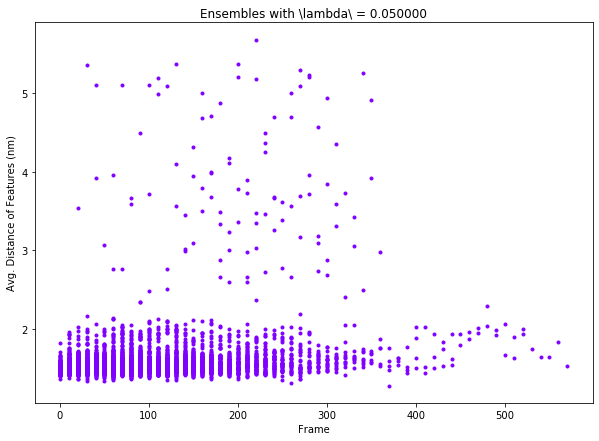

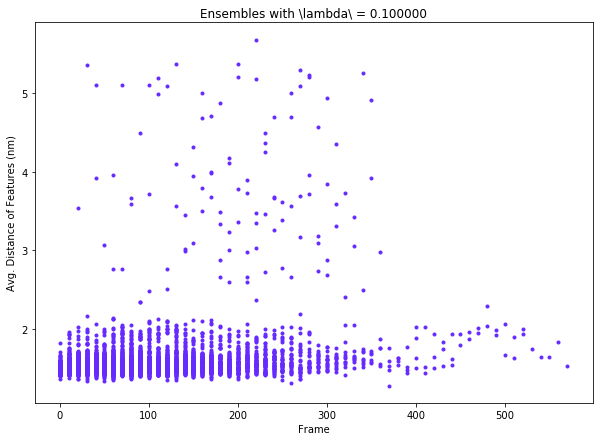

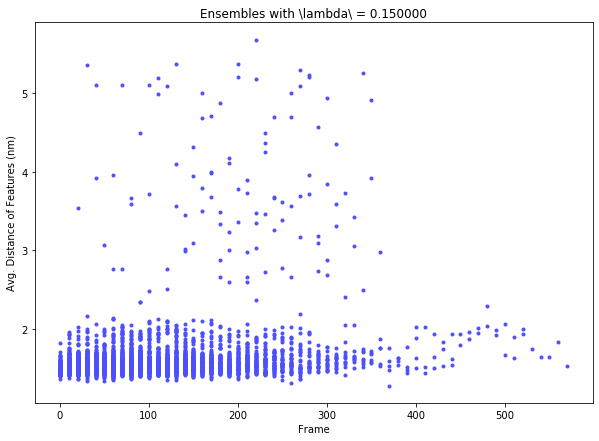

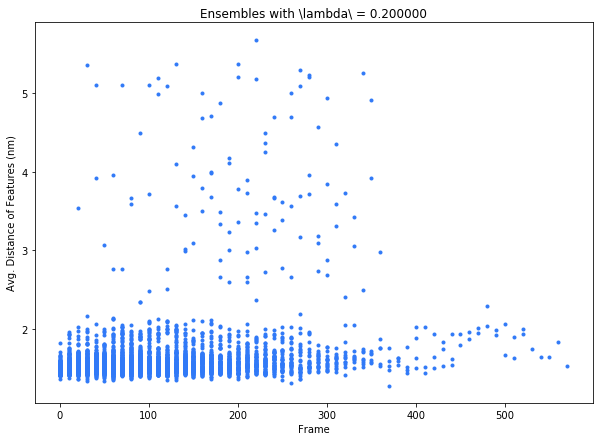

Error in callback <function flush_figures at 0x7f69dde2b950> (for post_execute):


KeyboardInterrupt: 

In [35]:
from matplotlib import cm
if not os.path.exists('%s/plots'%project_title):
    os.mkdir('%s/plots'%project_title)
    
colors = cm.rainbow(np.linspace(0,1,len(features_by_lambda)))
for i in tqdm.tqdm_notebook(range(len(features_by_lambda))): # ensemble
    plt.figure(i, figsize=(10,7))
    for j in range(len(features_by_lambda[i])): # trajectory
        for k in range(len(features_by_lambda[i][j]))[::10]: # frame
            print(k,np.average(features_by_lambda[i][j][k]))
            plt.plot(k,np.average(features_by_lambda[i][j][k]),color=colors[i], marker='.')
    plt.title('Ensembles with \lambda\ = %f'%(0.05*(i+1)))
    plt.ylabel('Avg. Distance of Features (nm)')
    plt.xlabel('Frame')
    plt.savefig('%s/plots/FEP_%d.png'%(project_title,i))
    
colors = cm.rainbow(np.linspace(0,1,len(features_by_umbrella)))
for i in tqdm.tqdm_notebook(range(len(features_by_umbrella))): # ensemble
    plt.figure(i+50, figsize=(10,7))
    for j in range(len(features_by_umbrella[i])): # trajectory
        for k in range(len(features_by_umbrella[i][j]))[::10]: # frame
            plt.plot(k,np.average(features_by_umbrella[i][j][k]),color=colors[i], marker='.')
    plt.title('Ensembles with Umbrellas, d = %f'%((i+1)/10))
    plt.ylabel('Avg. Distance of Features (nm)')
    plt.xlabel('Frame')
    plt.savefig('%s/plots/Umbrella_%d.png'%(project_title,i))

In [70]:
feature_files, ensemble_indices = [],[]
for i in range(runs):
    run_feature_files = sorted(glob.glob(project_title + '/features/P*R%d_*npy'%i))
    ensemble_indices.append(len(run_feature_files))
    feature_files += run_feature_files
all_features = [ np.load(filename) for filename in feature_files]

features = []
for i in range(len(all_features)): # trajectory
    features.append([])
    for j in range(len(all_features[i])): # frame
        features[i].append(np.average(all_features[i][j]))
        print(all_features[i][j])
        sys.exit(())

print(features[0])
    

[ 1.70941091  1.83016229  1.71850574  1.62301004  1.41241825  1.54238379
  1.8192476   1.68932247  1.62329745  1.38936174  1.85894275  1.21760476
  1.21412432  1.04724455  0.9543485   0.79262793  0.8792026   1.25404525
  1.11943829  1.04081225  0.87266254  1.27026665  0.9093945   1.20688903
  1.18425274  1.22322285  1.04496133  1.20336306  1.1320523   0.94149101
  1.05764914  0.83039945  1.31329453  1.03322995  1.49581909  1.64705396
  1.71707022  1.46419621  1.79097605  1.32088161  1.21025503  1.32988548
  1.06746674  1.55251873  1.46843517  1.99779403  2.19888568  2.29283023
  2.04065299  2.37636518  1.78756762  1.69633996  1.85397887  1.60926926
  2.04992938  1.44168973  1.93715012  2.23190284  2.33973551  2.07151055
  2.4969852   1.70096016  1.69052494  1.80678701  1.59966159  1.94854677
  1.05697215  1.58838451  1.90542674  2.05999374  1.84901977  2.22648883
  1.33889282  1.32304549  1.52012813  1.37342119  1.63864958]


SystemExit: 

ValueError: 1.2000000000000002 is not in list

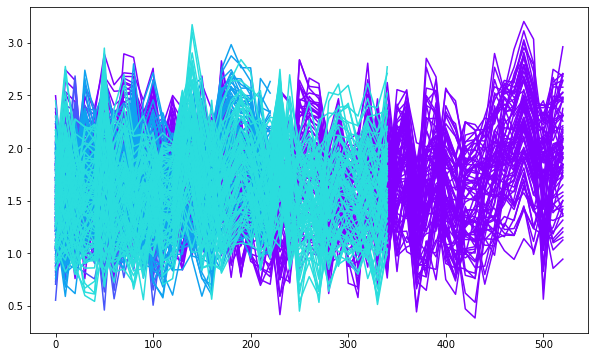

In [80]:

all_distances,all_lambdas = [],[]
for i in range(200):
    all_distances.append((2 + i%10)*0.2) # FEP / UMB
    all_lambdas.append((1 + int(i/10))*0.05)
distances = [0.2+(0.2*(x+1)) for x in range(10)]
lambdas = [0.05*(x+1) for x in range(20)]

colors = cm.rainbow(np.linspace(0,1,len(lambdas)))
for i in tqdm.tqdm_notebook(distances):
    plt.figure(i, figsize=(10,6))
    for j in range(len(all_distances)):
        if all_distances[j] == i:
            plt.plot(range(len(all_features[j]))[::10],all_features[j][::10],color=colors[lambdas.index(all_lambdas[j])])
    plt.savefig('%s/plots/UMB_%f.png'%(project_title,i))
    plt.close()
    
colors = cm.rainbow(np.linspace(0,1,len(distances)))
for i in tqdm.tqdm_notebook(lambdas):
    plt.figure(i+20, figsize=(10,6))
    for j in range(len(all_lambdas)):
        if all_lambdas[j] == i:
            plt.plot(range(len(all_features[j]))[::10],all_features[j][::10],color=colors[distances.index(all_distances[j])])
    plt.savefig('%s/plots/FEP_%f.png'%(project_title,i))
    plt.close()
    

            

# 